In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.cifar100.load_data()
X_train,X_test = X_train/255,X_test/255

In [3]:
tree_outputs = max(np.max(Y_train), np.max(Y_test)) + 1
tree_depth = int(np.ceil(np.log2(tree_outputs)))
tree_nodes = 2**tree_depth - 1
tree_outputs, tree_depth, tree_nodes

(100, 7, 127)

In [4]:
def tree_path_and_label(x):
    label,path = [],[0]
    for i in range(tree_depth):
        k = 2**(tree_depth-i-1)
        if x >= k:
            label.append(1)
            path.append(2*path[-1]+2)
            x = x - k
        else:
            label.append(0)
            path.append(2*path[-1]+1)
    path.pop()
    return np.array(path), np.array(label)
Y_train_path = np.array([tree_path_and_label(y) for y in Y_train])
Y_train_path, Y_train_label = Y_train_path[:,0,:], Y_train_path[:,1,:]
Y_test_path = np.array([tree_path_and_label(y) for y in Y_test])
Y_test_path, Y_test_label = Y_test_path[:,0,:], Y_test_path[:,1,:]

In [5]:
X = X_input = keras.layers.Input(X_train.shape[1:])
X = keras.layers.BatchNormalization()(X)
for i in range(5):
    for _ in range(4):
        X = keras.layers.SeparableConv2D(2**(i+3), (3,3), padding='same')(X)
        X = keras.layers.BatchNormalization()(X)
        X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling2D()(X)
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(256)(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(256)(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(256)(X)
M = keras.Model(X_input, X)
X_path = X_path_input = keras.layers.Input(Y_train_path.shape[1:])
X_path = keras.layers.Embedding(tree_nodes+1, 256)(X_path)
T = keras.Model(X_path_input, X_path)
X = X_input = keras.layers.Input(X_train.shape[1:])
X = M(X)
X = keras.layers.RepeatVector(Y_train_path.shape[1])(X)
X_path = X_path_input = keras.layers.Input(Y_train_path.shape[1:])
X_path = T(X_path)
X = keras.layers.Lambda(
    lambda x: K.sum(x[0]*x[1], axis=-1),
    output_shape=Y_train_label.shape[1:])([X,X_path])
X = keras.layers.Activation('sigmoid')(X)
X_outputs = []
for i in range(Y_train_label.shape[-1]):
    X_outputs.append(keras.layers.Lambda(
        lambda x,a: x[:,a:a+1],
        arguments={'a':i},
        output_shape=(1,))(X))
G = keras.Model([X_input,X_path_input], X_outputs)
G.compile('nadam', 'binary_crossentropy', ['acc'])
G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256)          255807      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 7, 256)       0           model_1[1][0]                    
__________________________________________________________________________________________________
model_2 (M

In [6]:
hist = G.fit(
    [X_train, Y_train_path],
    np.split(Y_train_label, Y_train_label.shape[-1], axis=-1),
    validation_data=([X_test, Y_test_path],
        np.split(Y_test_label, Y_test_label.shape[-1], axis=-1)),
    batch_size=128, epochs=20)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 64s 1ms/step - loss: 4.2066 - lambda_2_loss: 0.6496 - lambda_3_loss: 0.5646 - lambda_4_loss: 0.6298 - lambda_5_loss: 0.6539 - lambda_6_loss: 0.6077 - lambda_7_loss: 0.5776 - lambda_8_loss: 0.5234 - lambda_2_acc: 0.6412 - lambda_3_acc: 0.6675 - lambda_4_acc: 0.6189 - lambda_5_acc: 0.5820 - lambda_6_acc: 0.6347 - lambda_7_acc: 0.6807 - lambda_8_acc: 0.7216 - val_loss: 4.5630 - val_lambda_2_loss: 0.6760 - val_lambda_3_loss: 0.5772 - val_lambda_4_loss: 0.7106 - val_lambda_5_loss: 0.7116 - val_lambda_6_loss: 0.6735 - val_lambda_7_loss: 0.6279 - val_lambda_8_loss: 0.5862 - val_lambda_2_acc: 0.6204 - val_lambda_3_acc: 0.6782 - val_lambda_4_acc: 0.6180 - val_lambda_5_acc: 0.5910 - val_lambda_6_acc: 0.6639 - val_lambda_7_acc: 0.7085 - val_lambda_8_acc: 0.7416
Epoch 2/20
50000/50000 [==============================] - 56s 1ms/step - loss: 3.8543 - lambda_2_loss: 0.6404 - lambda_3_loss: 0.54

Epoch 11/20
50000/50000 [==============================] - 56s 1ms/step - loss: 2.9984 - lambda_2_loss: 0.5944 - lambda_3_loss: 0.4675 - lambda_4_loss: 0.5114 - lambda_5_loss: 0.4982 - lambda_6_loss: 0.3806 - lambda_7_loss: 0.3066 - lambda_8_loss: 0.2397 - lambda_2_acc: 0.6830 - lambda_3_acc: 0.7564 - lambda_4_acc: 0.7336 - lambda_5_acc: 0.7420 - lambda_6_acc: 0.8187 - lambda_7_acc: 0.8623 - lambda_8_acc: 0.8946 - val_loss: 3.5727 - val_lambda_2_loss: 0.6343 - val_lambda_3_loss: 0.5172 - val_lambda_4_loss: 0.5825 - val_lambda_5_loss: 0.5789 - val_lambda_6_loss: 0.4992 - val_lambda_7_loss: 0.4218 - val_lambda_8_loss: 0.3388 - val_lambda_2_acc: 0.6599 - val_lambda_3_acc: 0.7368 - val_lambda_4_acc: 0.6933 - val_lambda_5_acc: 0.7014 - val_lambda_6_acc: 0.7647 - val_lambda_7_acc: 0.8130 - val_lambda_8_acc: 0.8577
Epoch 12/20
50000/50000 [==============================] - 56s 1ms/step - loss: 2.9489 - lambda_2_loss: 0.5889 - lambda_3_loss: 0.4633 - lambda_4_loss: 0.5045 - lambda_5_loss: 0.49

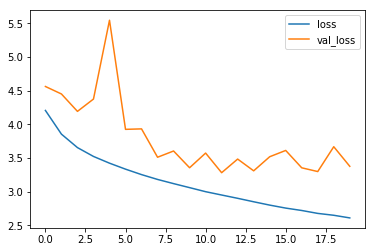

In [7]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [8]:
def sigmoid(x):
    return np.where(x >= 0, 
        1 / (1 + np.exp(-x)), 
        np.exp(x) / (1 + np.exp(x)))
acc = M.predict(X_test, batch_size=128)
tree_embedding = T.get_weights()[0]
acc = np.tile(acc[:,np.newaxis,:], (1,Y_test_path.shape[-1],1))
acc = acc * tree_embedding[Y_test_path]
acc = np.sum(acc, axis=-1)
acc = sigmoid(acc)
acc = np.where(acc >= 0.5, 1, 0)
acc = np.all(acc == Y_test_label, axis=-1)
np.sum(acc) / Y_test_label.shape[0]

0.2078